In [1]:
import os, glob, json
import pickle
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import re
import numpy as np
from scipy import stats
from collections import Counter, defaultdict
import random, math
from tqdm import tqdm
import platform

# print machine name
machine_name = platform.node().split(".")[0]
print(machine_name)

# print available scratch directories
print(" ".join(os.listdir(f"/{machine_name}")))
scr_dir = os.listdir(f"/{machine_name}")[0]

DISK_IO_DIR = "/{}/{}/yiweil".format(machine_name,scr_dir)
print(DISK_IO_DIR)
if not os.path.exists(DISK_IO_DIR):
    os.mkdir(DISK_IO_DIR)
    
from utils import *
print(STANZA_DIR)

john10
scr1
/john10/scr1/yiweil
Using Δ|&#8710;|∆|!delta as regex for comments awarding delta.
Found 422 conversations which are manually checked to be true climate convos.
/nlp/u/yiweil/combined_stanza_output_with_ner_embed_removed


# Load corpus

In [2]:
from convokit import Corpus#, Speaker, download
AVAILABLE_CORP = ['full_cmv','matched_cmv_subsample','gen_reddit','switchboard']
corp_name_to_filepath = {
                         'full_cmv': '/u/scr/yiweil/convokit_corpora/my-cmv-corpus_1-1-2010_to_09-24-2021',
                         'matched_cmv_subsample': '/u/scr/yiweil/subsampled_cmv_corpus',
                         'gen_reddit':'/u/scr/yiweil/datasets/convokit/reddit-corpus-small',
                         'switchboard':'/sailhome/yiweil/.convokit/downloads/switchboard-corpus'
                        }

In [3]:
corp_to_analyze = {'full_cmv': None}#,'gen_reddit': None,'switchboard':None}
#corp_to_analyze.update({'matched_cmv_subsample': None})

for corp_name in corp_to_analyze:
    if corp_to_analyze[corp_name] is None:
        print("Loading corpus: {}...".format(corp_name))
        corp_to_analyze[corp_name] = Corpus(filename=corp_name_to_filepath[corp_name])
        corp_to_analyze[corp_name].print_summary_stats()
        print('\n')
        
        # Update full meta for conversations if corpus is not `matched_cc_cmv_subsample` (contains comments only, by design)
        if corp_name in {'full_cmv','matched_cmv_subsample','gen_reddit','switchboard'}:
            for utt in corp_to_analyze[corp_name].iter_utterances():
                if utt.id == utt.conversation_id: # not a comment but a post
                    convo = corp_to_analyze[corp_name].get_conversation(utt.id)
                    meta_dict = utt.meta
                    for key in meta_dict:
                        convo.add_meta(key, meta_dict[key])
                    convo.speaker = utt.speaker
                        
        print("Annotating {}...".format(corp_name))
        corp_to_analyze[corp_name] = filter_bots_mods_removed(corp_to_analyze[corp_name])
        print('\n')
        
        if corp_name in {'matched_cmv_subsample','matched_cc_cmv_subsample'}:
            print("Annotating generic utterances from {}...".format(corp_name))
            corp_to_analyze[corp_name] = filter_generic_comments(
                corp_to_analyze[corp_name], 
                GENERIC_REGEX_PATS,
                fname=f'generic_dict_{corp_name}.pkl')
            corp_to_analyze[corp_name].print_summary_stats()
            print('\n')
            
        print("Removing footnotes and in-line embedded text from {}...".format(corp_name))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            utt.text = cleanup(utt.text)
            
        print("Annotating removed/deleted comments in {}...".format(corp_name))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            utt.meta['is_removed'] = (utt.text == '[removed]') or (utt.text == '[deleted]')
            
        print("Annotating path information w/ version ignoring OP...".format(corp_name))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            if (utt.id[:2] == 't1') and (utt.meta['outcome'] != -1):
                utt.meta['path_to_outcome_OP_removed'] = get_path_to_outcome_utt(corp_to_analyze[corp_name],
                                                                                 utt, 
                                                                                 ignore_OP=True,
                                                                                 ignore_removed=False)
        
        print("Distribution of delta outcomes:")
        print(Counter([utt.meta['outcome'] for utt in corp_to_analyze['full_cmv'].iter_utterances()
              if utt.id[:2]=='t1']))

Loading corpus: full_cmv...
Number of Speakers: 207110
Number of Utterances: 3243830
Number of Conversations: 84258


Annotating full_cmv...
Filtering speakers with usernames ending in '-bot'...
Found 2896720 non-deleted/removed utterances not written by a bot or moderator.


Removing footnotes and in-line embedded text from full_cmv...


3243830it [01:46, 30398.65it/s]


Annotating removed/deleted comments in full_cmv...


3243830it [00:24, 134016.29it/s]


Annotating path information w/ version ignoring OP...


3243830it [00:50, 64058.91it/s]


Distribution of delta outcomes:
Counter({-1: 1919491, '-delta': 1204715, '+delta': 35366})


# Visualize distributions of structural features

In [4]:
# Structural features/predictors

def is_outcome_leaf(utt):
    """Returns whether a comment represents an outcome node."""
    return (utt.id[:2] == 't1') and (utt.meta['outcome'] != -1)

def is_OP_utt(corp,utt):
    return utt.speaker.id == corp.get_utterance(utt.conversation_id).speaker.id

def get_path_to_outcome_utt(corp, outcome_utt, ignore_OP=True, ignore_removed=True):
    """Returns the path of utterance IDs (excluding parent post) all the way to the outcome_utt (incl.)."""
    assert is_outcome_leaf(outcome_utt)
    if ignore_OP:
        path_to_outcome_utt = [u for u in outcome_utt.meta['path_to_outcome']
                               if not is_OP_utt(corp, corp.get_utterance(u))]
    else:
        path_to_outcome_utt = outcome_utt.meta['path_to_outcome']
    if ignore_removed:
        path_to_outcome_utt = [u for u in path_to_outcome_utt
                               if not corp.get_utterance(u).meta['is_removed']]
    return path_to_outcome_utt

def get_depth(corp, outcome_utt, ignore_OP=True, ignore_removed=False):
    """Returns the length measured as the depth of a sub-tree."""
    assert is_outcome_leaf(outcome_utt)
    path_to_outcome_utt = get_path_to_outcome_utt(corp, outcome_utt, ignore_OP=ignore_OP, 
                                                  ignore_removed=ignore_removed)
    return len(path_to_outcome_utt)

def get_total_num_words(corp, outcome_utt, ignore_OP=True, ignore_removed=True):
    """Returns the length measured as the total number of words in a sub-tree."""
    assert is_outcome_leaf(outcome_utt)
    path_to_outcome_utt = get_path_to_outcome_utt(corp, outcome_utt, ignore_OP=ignore_OP)
    #if i
    num_words = sum([len(corp.get_utterance(utt_id).text.split()) 
                     for utt_id in path_to_outcome_utt])
    return num_words

def get_mean_num_words(corp, outcome_utt, ignore_OP=True, ignore_removed=True):
    """Returns the length measured as the mean number of words per comment in a sub-tree."""
    assert is_outcome_leaf(outcome_utt)
    path_to_outcome_utt = get_path_to_outcome_utt(corp, outcome_utt, ignore_OP=ignore_OP)
    mean_num_words = np.average([len(corp.get_utterance(utt_id).text.split()) 
                                 for utt_id in path_to_outcome_utt])
    return mean_num_words
    
def get_order(corp,outcome_utt):
    """Returns the order of the top-level comment of a sub-tree."""
    assert is_outcome_leaf(outcome_utt)
    first_utt_in_subtree = outcome_utt.meta['path_to_outcome'][0]

    top_level_timestamps = []
    for top_level_utt_id in corp_to_analyze['full_cmv'].get_conversation(
        outcome_utt.conversation_id).meta['top_level_comments']:
        top_level_timestamps.append((top_level_utt_id,
                                     corp_to_analyze['full_cmv'].get_utterance(top_level_utt_id).timestamp))
    sorted_timestamps = sorted(top_level_timestamps, key=lambda x:x[1], reverse=False)
    sorted_top_level_utt_ids = [x[0] for x in sorted_timestamps]
    return sorted_top_level_utt_ids.index(first_utt_in_subtree)+1
    
    first_utt_in_subtree = corp.get_utterance(outcome_utt.meta['path_to_outcome'][0])
    convo = corp.get_conversation(outcome_utt.conversation_id)
    for path in convo.get_root_to_leaf_paths():
        for depth,u in enumerate(path):
            if u.id == first_utt_in_subtree.id:
                return depth+1
            
def get_rel_timestamp_subtree(corp,outcome_utt):
    """
    Returns the time elapsed in seconds between the first comment of a sub-tree and the OG post.
    """
    first_utt_in_subtree = corp.get_utterance(outcome_utt.meta['path_to_outcome'][0])
    return first_utt_in_subtree.timestamp - corp.get_utterance(outcome_utt.conversation_id).timestamp

def get_abs_timestamp_subtree(corp,outcome_utt):
    """
    Returns the absolute timestamp of the first comment of a sub-tree.
    """
    first_utt_in_subtree = corp.get_utterance(outcome_utt.meta['path_to_outcome'][0])
    return first_utt_in_subtree.timestamp

Are there any subtrees composed entirely of removed/delted comments?

In [5]:
def get_utt(utt_id,corp=corp_to_analyze['full_cmv']):
    return corp.get_utterance(utt_id)

subtree_outcome_utts = [utt for utt in corp_to_analyze['full_cmv'].iter_utterances()
                        if is_outcome_leaf(utt)]

all_removed_outcome_utt_ids = []
for outcome_utt in tqdm(subtree_outcome_utts):
    path = [get_utt(u_id) for u_id in outcome_utt.meta['path_to_outcome_OP_removed']]
    if np.all([utt.meta['is_removed'] for utt in path]):
        all_removed_outcome_utt_ids.append(outcome_utt.id)
print(f"Found {len(all_removed_outcome_utt_ids)} subtrees with entirely removed/deleted comments.")

100%|██████████| 1240081/1240081 [00:47<00:00, 26349.14it/s]

Found 36572 subtrees with entirely removed/deleted comments.


Quick sanity check of a few examples:

In [11]:
removed_exs = [all_removed_outcome_utt_ids[0], all_removed_outcome_utt_ids[-1]]
for ex in removed_exs:
    print('******')
    print(get_utt(ex).meta['path_to_outcome_OP_removed'])
    print('\n'.join([get_utt(u_id).text for u_id in get_utt(ex).meta['path_to_outcome_OP_removed']]))

******
['t1_cotd1mx', 't1_cotd93n']
[removed]
[removed]
******
[]



This represents 2.9% of all subtrees. Of these, 1548 subtrees = 4.4% are +delta subtrees. A shame...

In [13]:
Counter([get_utt(outcome_utt).meta['outcome'] for outcome_utt in all_removed_outcome_utt_ids])

Counter({'-delta': 35024, '+delta': 1548})

In [16]:
pickle.dump(set(all_removed_outcome_utt_ids),open('removed_subtrees.pkl','wb'))

removed_outcome_ids = pickle.load(open('removed_subtrees.pkl','rb'))
def is_removed_subtree(subtree_outcome_utt,path_to_removed_subtrees=removed_outcome_ids):
    return subtree_outcome_utt in removed_outcome_ids

print(is_removed_subtree(all_removed_outcome_utt_ids[0])) # expected: True
print(is_removed_subtree(all_removed_outcome_utt_ids[1])) # expected: True

True
True


In [17]:
to_plot_df = pd.DataFrame({
    'subtree_outcome_utt_id': [utt.id for utt in subtree_outcome_utts],
    'conversation_id': [utt.conversation_id for utt in subtree_outcome_utts],
    'count': [1 for utt in subtree_outcome_utts],
    '+delta count': [1 if utt.meta['outcome'] == '+delta' else 0 for utt in subtree_outcome_utts],
    '-delta count': [1 if utt.meta['outcome'] == '-delta' else 0 for utt in subtree_outcome_utts],
    'outcome': [utt.meta['outcome'] for utt in subtree_outcome_utts],
    'depth': [get_depth(corp_to_analyze['full_cmv'], utt, ignore_OP=True) for utt in subtree_outcome_utts],
    'order': [get_order(corp_to_analyze['full_cmv'],utt)
              for utt in subtree_outcome_utts],
    'time_elapsed': [get_rel_timestamp_subtree(corp_to_analyze['full_cmv'],utt) 
                     for utt in subtree_outcome_utts],
    'timestamp': [get_abs_timestamp_subtree(corp_to_analyze['full_cmv'],utt) 
                  for utt in subtree_outcome_utts]})
to_plot_df['year'] = to_plot_df['timestamp'].apply(
    lambda x: datetime.utcfromtimestamp(x).year)
to_plot_df['month'] = to_plot_df['timestamp'].apply(
    lambda x: datetime.utcfromtimestamp(x).month)
to_plot_df['year_mo'] = to_plot_df.apply(
    lambda x: f"{x['year']}-{x['month']}", axis=1)

to_plot_df.head()

,subtree_outcome_utt_id,conversation_id,count,+delta count,-delta count,outcome,depth,order,time_elapsed,timestamp,year,month,year_mo
0,t1_djhcrq8,t3_6juc9p,1,0,1,-delta,1,21,12519.0,1.498598e+09,2017,6,2017-6
1,t1_csajf84,t3_3a7ys8,1,0,1,-delta,2,2,1823.0,1.434584e+09,2015,6,2015-6
2,t1_g99brae,t3_jdn5or,1,0,1,-delta,2,11,2724.0,1.603054e+09,2020,10,2020-10
3,t1_cqxesmu,t3_34rgpv,1,0,1,-delta,3,4,879.0,1.430694e+09,2015,5,2015-5
4,t1_cgmavct,t3_22dcc4,1,0,1,-delta,2,2,1076.0,1.396818e+09,2014,4,2014-4


In [10]:
to_plot_df.describe()

,count,+delta count,-delta count,depth,total_num_words,mean_num_words,order,time_elapsed,timestamp,year,month
count,1240081.0,1.240081e+06,1.240081e+06,1.240081e+06,1.240081e+06,1.240081e+06,1.240081e+06,1.240081e+06,1.240081e+06,1.240081e+06,1.240081e+06
mean,1.0,2.851910e-02,9.714809e-01,3.351767e+00,2.852487e+02,9.448167e+01,1.111991e+01,2.679715e+04,1.513812e+09,2.017518e+03,5.948049e+00
std,0.0,1.664506e-01,1.664506e-01,2.382555e+00,3.171778e+02,9.695754e+01,1.830654e+01,3.327077e+05,7.675215e+07,2.424607e+00,3.271285e+00
min,1.0,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.358442e+09,2.013000e+03,1.000000e+00
25%,1.0,0.000000e+00,1.000000e+00,1.000000e+00,8.000000e+01,3.755556e+01,3.000000e+00,1.110000e+03,1.446610e+09,2.015000e+03,3.000000e+00
50%,1.0,0.000000e+00,1.000000e+00,3.000000e+00,1.900000e+02,6.642857e+01,6.000000e+00,3.553000e+03,1.515577e+09,2.018000e+03,6.000000e+00
75%,1.0,0.000000e+00,1.000000e+00,5.000000e+00,3.760000e+02,1.165000e+02,1.200000e+01,1.470800e+04,1.584505e+09,2.020000e+03,9.000000e+00
max,1.0,1.000000e+00,1.000000e+00,1.000000e+01,1.105000e+04,1.862000e+03,2.810000e+02,7.447853e+07,1.633411e+09,2.021000e+03,1.200000e+01


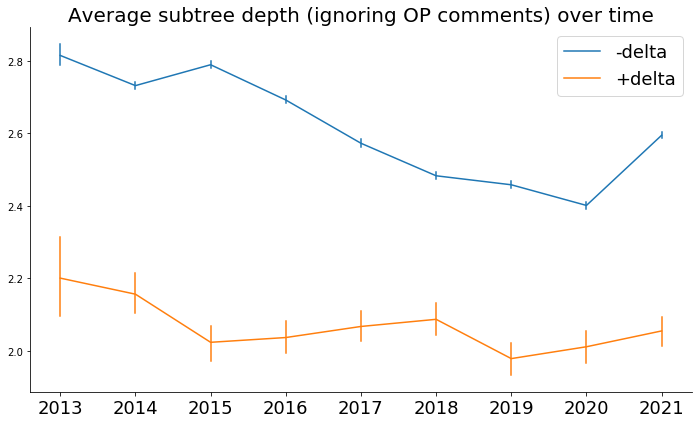

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='year',y='depth',hue='outcome',data=to_plot_df,
             err_style="bars",estimator='mean',ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(range(2012,2022),fontsize=18)
ax.set_title('Average subtree depth (ignoring OP comments) over time',fontsize=20)
ax.legend(bbox_to_anchor=(1,1), title="", fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('figs/mean_depth_per_subtree_over_time.png',dpi=200)

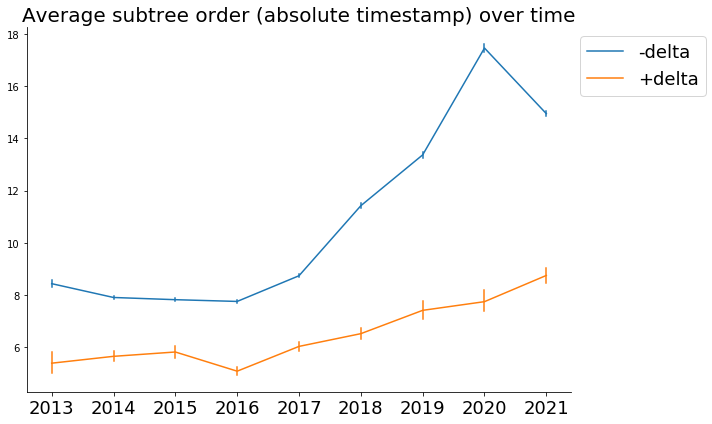

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='year',y='order',hue='outcome',data=to_plot_df,
             err_style="bars",estimator='mean',ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(range(2012,2022),fontsize=18)
ax.set_title('Average subtree order (absolute timestamp) over time',fontsize=20)
ax.legend(bbox_to_anchor=(1,1), title="", fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('figs/mean_order_per_subtree_over_time.png',dpi=200)

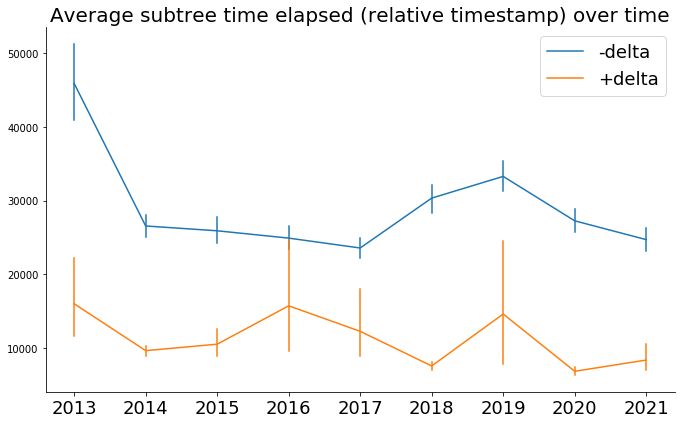

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='year',y='time_elapsed',hue='outcome',data=to_plot_df,
             err_style="bars",estimator='mean',ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(range(2012,2022),fontsize=18)
ax.set_title('Average subtree time elapsed (relative timestamp) over time',fontsize=20)
ax.legend(bbox_to_anchor=(1,1), title="", fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('figs/mean_time_elapsed_per_subtree_over_time.png',dpi=200)

In [22]:
# Separate df excluding all-removed subtrees to visualize length in total/mean #words

# to_plot_df = pd.DataFrame({
#     'subtree_outcome_utt_id': [utt.id for utt in subtree_outcome_utts if not is_removed_subtree(utt.id)],
#     'conversation_id': [utt.conversation_id for utt in subtree_outcome_utts if not is_removed_subtree(utt.id)],
#     'count': [1 for utt in subtree_outcome_utts if not is_removed_subtree(utt.id)],
#     '+delta count': [1 if utt.meta['outcome'] == '+delta' else 0 for utt in subtree_outcome_utts 
#                      if not is_removed_subtree(utt.id)],
#     '-delta count': [1 if utt.meta['outcome'] == '-delta' else 0 for utt in subtree_outcome_utts
#                      if not is_removed_subtree(utt.id)],
#     'outcome': [utt.meta['outcome'] for utt in subtree_outcome_utts
#                 if not is_removed_subtree(utt.id)],
#     'total_num_words': [get_total_num_words(corp_to_analyze['full_cmv'], utt, ignore_OP=True)
#                         for utt in subtree_outcome_utts if not is_removed_subtree(utt.id)],
#     'mean_num_words': [get_mean_num_words(corp_to_analyze['full_cmv'], utt, ignore_OP=True)
#                        for utt in subtree_outcome_utts if not is_removed_subtree(utt.id)]})
to_plot_df['timestamp'] = [get_abs_timestamp_subtree(corp_to_analyze['full_cmv'],utt) 
                           for utt in subtree_outcome_utts if not is_removed_subtree(utt.id)]
to_plot_df['year'] = to_plot_df['timestamp'].apply(
    lambda x: datetime.utcfromtimestamp(x).year)
to_plot_df['month'] = to_plot_df['timestamp'].apply(
    lambda x: datetime.utcfromtimestamp(x).month)
to_plot_df['year_mo'] = to_plot_df.apply(
    lambda x: f"{x['year']}-{x['month']}", axis=1)

print(to_plot_df.head())
print(to_plot_df.describe())

  subtree_outcome_utt_id conversation_id  count  +delta count  -delta count  \
0             t1_djhcrq8       t3_6juc9p      1             0             1   
1             t1_csajf84       t3_3a7ys8      1             0             1   
2             t1_g99brae       t3_jdn5or      1             0             1   
3             t1_cqxesmu       t3_34rgpv      1             0             1   
4             t1_cgmavct       t3_22dcc4      1             0             1   

  outcome  total_num_words  mean_num_words     timestamp  year  month  year_mo  
0  -delta              227           227.0  1.498598e+09  2017      6   2017-6  
1  -delta              246           123.0  1.434584e+09  2015      6   2015-6  
2  -delta              129            64.5  1.603054e+09  2020     10  2020-10  
3  -delta              146           146.0  1.430694e+09  2015      5   2015-5  
4  -delta              134            67.0  1.396818e+09  2014      4   2014-4  
           count  +delta count  -delta 

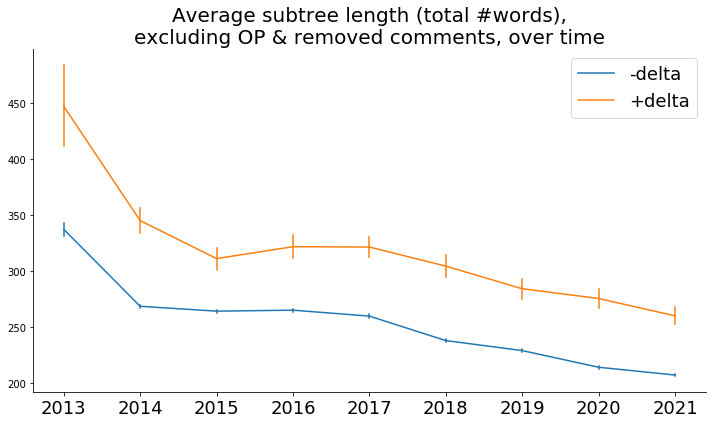

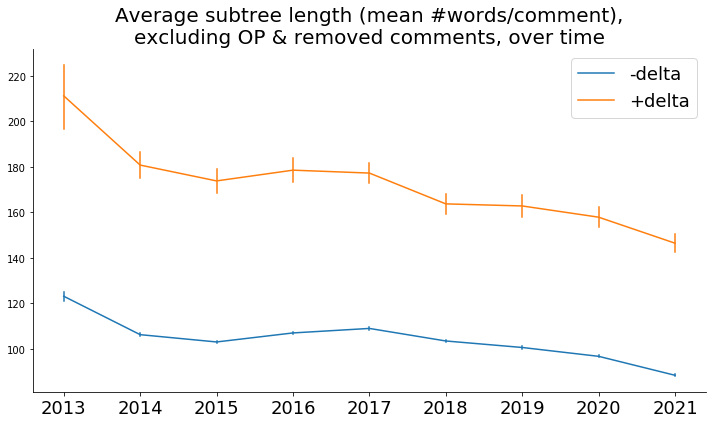

In [24]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='year',y='total_num_words',hue='outcome',data=to_plot_df,
             err_style="bars",estimator='mean',ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(range(2012,2022),fontsize=18)
ax.set_title('Average subtree length (total #words),\nexcluding OP & removed comments, over time',fontsize=20)
ax.legend(bbox_to_anchor=(1,1), title="", fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('figs/mean_total_words_per_subtree_over_time.png',dpi=200)

fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='year',y='mean_num_words',hue='outcome',data=to_plot_df,
             err_style="bars",estimator='mean',ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(range(2012,2022),fontsize=18)
ax.set_title('Average subtree length (mean #words/comment),\nexcluding OP & removed comments, over time',fontsize=20)
ax.legend(bbox_to_anchor=(1,1), title="", fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('figs/mean_average_words_per_subtree_over_time.png',dpi=200)